In [1]:
%pip install -e git+https://github.com/cldf-datasets/wals.git@v2020#egg=cldfbench_wals --quiet

  DEPRECATION: Legacy editable install of cldfbench_wals from git+https://github.com/cldf-datasets/wals.git@v2020#egg=cldfbench_wals (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
Note: you may need to restart the kernel to use updated packages.


In [2]:
from cldfbench import get_dataset
import pandas as pd
import numpy as np
from IPython.display import display
from conlanger.utils import display_rows

In [3]:
wals = get_dataset("wals").cldf_reader()

In [4]:
lang_df = pd.DataFrame(wals.iter_rows("LanguageTable"))[["ID", "Name", "ISO639P3code"]]
display(lang_df.head(3))
lang_df.shape

,ID,Name,ISO639P3code
0,aab,Arapesh (Abu),None
1,aar,Aari,aiw
2,aba,Abau,aau


(2662, 3)

In [5]:
# param_df = (
#     pd.DataFrame(wals.iter_rows("ParameterTable"))
#     .set_index(["Area", "Chapter"])
#     .drop(columns=["Description", "Contributor_ID"])
# )

# param_df = param_df[
#     ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
# ]

# areas = param_df.index.unique(level="Area")
# chapters = param_df.index.unique(level="Chapter")

# print(f"Areas: {areas.shape[0]}")
# print(f"Chapters: {chapters.shape[0]}")
# print(f"Parameters: {param_df.shape[0]}")

# parameters = param_df[["ID", "Name"]].to_numpy()

# params_by_area = [param_df[param_df.index.get_level_values("Area") == area]["ID"].to_numpy() for area in areas]
# max_size = max([len(a) for a in params_by_area])
# params_by_area = np.array([np.hstack([a, np.full(max_size - a.size, "")]) for a in params_by_area])

# params_by_area.shape, parameters.shape

In [6]:
param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .drop(columns=["Description", "Contributor_ID"])
)

word_order_negation = ["Position of Negative Morpheme With Respect to Subject, Object, and Verb", "Order of Negative Morpheme and Verb"]

param_df.loc[param_df["Chapter"].isin(word_order_negation), "Area"] = "Word Order - Negation"
# param_df.loc[param_df["Area"] == "Phonology", "Area"] = "Phonology & Morphology"
# param_df.loc[param_df["Area"] == "Morphology", "Area"] = "Phonology & Morphology"
# param_df.loc[param_df["Area"] == "Nominal Syntax", "Area"] = "Nominal Syntax & Verbal Categories"
# param_df.loc[param_df["Area"] == "Verbal Categories", "Area"] = "Nominal Syntax & Verbal Categories"
# param_df.loc[param_df["Area"] == "Complex Sentences", "Area"] = "Complex Sentences & Lexicon"
# param_df.loc[param_df["Area"] == "Lexicon", "Area"] = "Complex Sentences & Lexicon"

param_df = param_df[
    ~param_df["Area"].isin(["Sign Languages", "Other"])
]

param_counts_by_area = param_df[["Area", "ID"]].groupby("Area", sort=False).agg(param_count=('ID', 'count'), params=('ID', list)).reset_index()
max_params_by_area = param_counts_by_area["param_count"].max()
display(param_counts_by_area)

param_counts_by_chapter = (param_df[["Area", "Chapter", "ID"]]
                           .groupby(["Area", "Chapter"], sort=False)
                           .agg(param_count=('ID', 'count'))
                           .reset_index()
)

params_by_chapter = (param_counts_by_chapter
                           .groupby("Area", sort=False)
                           .agg(total=('param_count', 'sum'), max=('param_count', 'max'), unique_count_per_chapter=('param_count', (lambda x: list(x.unique()))))
                           .reset_index()
)
display(params_by_chapter)


max_params_by_chapter = param_counts_by_chapter["param_count"].max()

all_parameters = np.array([l + [''] * (max_params_by_area - len(l)) for l in param_counts_by_area["params"].to_list()])


areas = param_df.Area.unique()
chapters = param_df.Chapter.unique()

print(f"Areas: {areas.shape[0]}")
print(f"Chapters: {chapters.shape[0]}")
print(f"Parameters: {param_df.shape[0]}")

parameters = param_df[["ID", "Name"]].to_numpy()

param_counts_by_area = [len(param_df[param_df["Area"] == area]["ID"]) for area in areas]
max_size = max(param_counts_by_area)

params_by_area = [param_df[param_df["Area"] == area]["ID"].to_numpy() for area in areas]
params_by_area = np.array([np.hstack([a, np.full(max_size - a.size, "")]) for a in params_by_area])

params_by_area.shape, parameters.shape

,Area,param_count,params
0,Phonology,20,"[1A, 2A, 3A, 4A, 5A, 6A, 7A, 8A, 9A, 10A, 10B,..."
1,Morphology,12,"[20A, 21A, 21B, 22A, 23A, 24A, 25A, 25B, 26A, ..."
2,Nominal Categories,29,"[30A, 31A, 32A, 33A, 34A, 35A, 36A, 37A, 38A, ..."
3,Nominal Syntax,8,"[58A, 58B, 59A, 60A, 61A, 62A, 63A, 64A]"
4,Verbal Categories,17,"[65A, 66A, 67A, 68A, 69A, 70A, 71A, 72A, 73A, ..."
5,Word Order,24,"[81A, 81B, 82A, 83A, 84A, 85A, 86A, 87A, 88A, ..."
6,Simple Clauses,26,"[98A, 99A, 100A, 101A, 102A, 103A, 104A, 105A,..."
7,Complex Sentences,7,"[122A, 123A, 124A, 125A, 126A, 127A, 128A]"
8,Lexicon,13,"[129A, 130A, 130B, 131A, 132A, 133A, 134A, 135..."
9,Word Order - Negation,32,"[143A, 143B, 143C, 143D, 143E, 143F, 143G, 144..."


,Area,total,max,unique_count_per_chapter
0,Phonology,20,2,"[1, 2]"
1,Morphology,12,2,"[1, 2]"
2,Nominal Categories,29,2,"[1, 2]"
3,Nominal Syntax,8,2,"[2, 1]"
4,Verbal Categories,17,2,"[1, 2]"
5,Word Order,24,7,"[2, 1, 7]"
6,Simple Clauses,26,2,"[1, 2]"
7,Complex Sentences,7,1,[1]
8,Lexicon,13,2,"[1, 2]"
9,Word Order - Negation,32,25,"[7, 25]"


Areas: 10
Chapters: 140
Parameters: 188


((10, 32), (188, 2))

In [7]:
code_df = pd.DataFrame(wals.iter_rows("CodeTable"))
code_df.head(3)

,ID,Parameter_ID,Name,Description,Number,icon
0,1A-1,1A,Small,Small,1,c0000dd
1,1A-2,1A,Moderately small,Moderately small,2,c9999ff
2,1A-3,1A,Average,Average,3,cffffff


In [8]:
value_df = (
    pd.DataFrame(wals.iter_rows("ValueTable"))
    .drop(columns=["ID", "Code_ID", "Comment", "Source", "Example_ID"])
    .merge(
        lang_df[["ID", "Name"]].rename(columns={"Name": "Language_Name"}),
        left_on="Language_ID",
        right_on="ID",
    )
)
value_df["Value"] = value_df["Value"].astype(int)
value_df["Language_Name"] = value_df["Language_Name"].str.split(" (", regex=False).str[0]

parameter_value_counts = value_df.Parameter_ID.value_counts()
high_parameter_value_counts = parameter_value_counts[parameter_value_counts > 750]

print(value_df.shape)
value_df = value_df[value_df.Parameter_ID.isin(high_parameter_value_counts.index)]
print(value_df.shape)
value_df.head(3)

(76475, 5)
(30217, 5)


,Language_ID,Parameter_ID,Value,ID,Language_Name
0,aab,81A,2,aab,Arapesh
1,aab,82A,1,aab,Arapesh
2,aab,83A,2,aab,Arapesh


In [9]:
example_df = pd.DataFrame(wals.iter_rows("ExampleTable"))
example_df.head(3)

,ID,Language_ID,Primary_Text,Analyzed_Word,Gloss,Translated_Text,Meta_Language_ID,Comment
0,igt-1,mnd,tāmen tōu zìxíngchē,"[tāmen, tōu, zìxíngchē]","[3PL, steal, bicycle]",They steal bicycles.,None,None
1,igt-2,mnd,[wǒ gěi nǐ de] shū,"[[wǒ, gěi, nǐ, de], shū]","[[1SG, give, 2SG, LINK], book]",the book [that I gave you],None,None
2,igt-3,nbd,dımın ıdw ṍww(ı),"[dımın, ıdw, ṍww(ı)]","[ten, eight, two]",82,None,None


In [10]:
def map_params(df):
    lang = df.to_numpy()
    lang_value_indices = np.isin(lang[:, 0], params_by_area).nonzero()

    param_indices = np.isin(params_by_area, lang[:, 0]).nonzero()

    result = np.zeros(params_by_area.shape)
    result[param_indices] = lang[:, 1][lang_value_indices]

    return result


values_by_language = value_df.groupby(["Language_ID", "Language_Name"])
unique_languages = np.array([[id, name] for (id, name), group in values_by_language])

language_parameters = np.stack(
            values_by_language.apply(map_params, include_groups=False).to_numpy()
        ).astype(int)

# remove languages with parameter values missing from some Areas
missing_areas_mask = language_parameters.sum(axis=2).astype(bool).sum(axis=1) > 5

selected_unique_languages = unique_languages[missing_areas_mask]
selected_language_parameters = np.array([np.hstack([arr[i][:n] for i, n in enumerate(param_counts_by_area)]) for arr in language_parameters[missing_areas_mask][:]])

language_parameters.shape, selected_language_parameters.shape, unique_languages.shape, selected_unique_languages.shape, parameters.shape

((1657, 10, 32), (852, 188), (1657, 2), (852, 2), (188, 2))

In [11]:
np.savez_compressed(
    "./data/language_parameters.npz",
    language_parameters=selected_language_parameters,
    languages=selected_unique_languages,
    parameters=parameters,
)

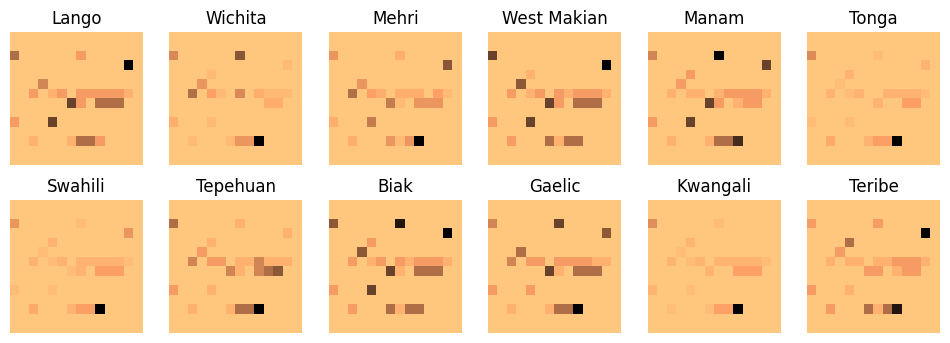

In [12]:
import matplotlib.pyplot as plt

r, c = 2, 6

gen = np.random.default_rng()
sample_indices = gen.choice(selected_unique_languages.shape[0], r * c, replace=False)
samples = selected_language_parameters[sample_indices]
sample_names = selected_unique_languages[:, 1][sample_indices]

sample_images = np.hstack([
    samples, 
    np.zeros((samples.shape[0], 8))
    ]).reshape(samples.shape[0], 14, 14)

display_rows(sample_images, titles=sample_names, cmap="copper_r", r=r, c=c, size=(12, 4))